In [2]:
import sys 
import os
sys.path.append(os.path.abspath('../networks'))
sys.path.append(os.path.abspath('../dev'))

from mads_datasets import DatasetFactoryProvider, DatasetType
from mltrainer.preprocessors import BasePreprocessor
from mltrainer import Trainer, TrainerSettings, ReportTypes, metrics

from helpers import get_last_accuracy_from_tensorboard

import torch.optim as optim
import torch

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import os

In [3]:
fashionfactory = DatasetFactoryProvider.create_factory(DatasetType.FASHION)
preprocessor = BasePreprocessor()

batchsize = 32

streamers = fashionfactory.create_datastreamer(batchsize=batchsize, preprocessor=preprocessor)
train = streamers["train"]
valid = streamers["valid"]

trainstreamer = train.stream()
validstreamer = valid.stream()

accuracy = metrics.Accuracy()
loss_func = torch.nn.CrossEntropyLoss()

2025-06-04 17:32:25.497 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /home/azureuser/.cache/mads_datasets/fashionmnist
2025-06-04 17:32:25.498 | INFO     | mads_datasets.base:download_data:124 - File already exists at /home/azureuser/.cache/mads_datasets/fashionmnist/fashionmnist.pt


In [4]:
from NN import NeuralNetwork

units = [512, 256, 128, 64, 32, 16]

epochs = 10
accuracies5 = []
dir = "modellogs/UNITS/EPOCH10/"

for units1 in units:
    row = []
    for units2 in units:
        logdir = f"{dir}u{units1}_u{units2}_e{epochs}"

        settings = TrainerSettings(
            epochs=epochs,
            metrics=[accuracy],
            logdir="modellogs",
            train_steps=100,
            valid_steps=100,
            reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.TOML]
        )

        model = NeuralNetwork(num_classes=10, units1=units1, units2=units2)
        settings.logdir = f"{dir}u{units1}_u{units2}_e{epochs}"

        trainer = Trainer(
            model=model,
            settings=settings,
            loss_fn=loss_func,
            optimizer=optim.Adam,
            traindataloader=trainstreamer,
            validdataloader=validstreamer,
            scheduler=optim.lr_scheduler.ReduceLROnPlateau
        )

        trainer.loop()
        
        tb_subdirs = [os.path.join(logdir, d) for d in os.listdir(logdir) if os.path.isdir(os.path.join(logdir, d))]

        # Zoek eerste subdir met tensorboard events
        tb_dir = next((d for d in tb_subdirs if any("events.out.tfevents" in f for f in os.listdir(d))), None)

        if tb_dir:
            last_acc = get_last_accuracy_from_tensorboard(tb_dir)
        else:
            last_acc = np.nan
        
        row.append(last_acc)
    accuracies5.append(row)

2025-06-04 16:46:42.634 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs/UNITS/EPOCH10/u512_u512_e10/20250604-164642
2025-06-04 16:46:46.460 | INFO     | mltrainer.trainer:__init__:68 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|██████████| 100/100 [00:00<00:00, 116.54it/s]
2025-06-04 16:46:47.574 | INFO     | mltrainer.trainer:report:209 - Epoch 0 train 0.9763 test 0.6872 metric ['0.7422']
100%|██████████| 100/100 [00:00<00:00, 173.96it/s]
2025-06-04 16:46:48.361 | INFO     | mltrainer.trainer:report:209 - Epoch 1 train 0.6448 test 0.5440 metric ['0.8066']
100%|██████████| 100/100 [00:00<00:00, 179.53it/s]
2025-06-04 16:46:49.119 | INFO     | mltrainer.trainer:report:209 - Epoch 2 train 0.5381 test 0.5239 metric ['0.8156']
100%|██████████| 100/100 [00:00<00:00, 180.67it/s]
2025-06-04 16:46:49.895 | INFO     | mltrainer.trainer:report:209 - Epoch 3 train 0.5190 test 0.6044 metric ['0.7797']
2025-06-04 16:46:49.896 | INF

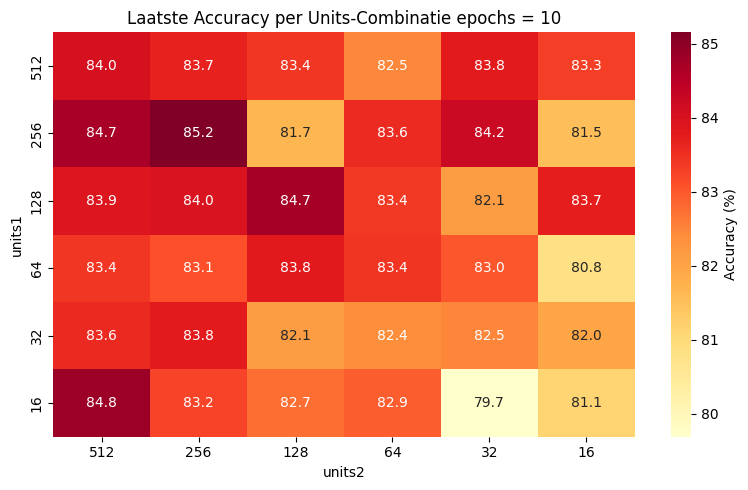

In [6]:
# Plot de heatmap
plt.figure(figsize=(8, 5))
ax = sns.heatmap(
    accuracies5,
    annot=True,
    fmt=".1f",
    xticklabels=units,
    yticklabels=units,
    cmap="YlOrRd",
    cbar_kws={'label': 'Accuracy (%)'}
)
ax.set_xlabel("units2")
ax.set_ylabel("units1")
ax.set_title("Laatste Accuracy per Units-Combinatie epochs = 10")
plt.tight_layout()
plt.savefig("heatmap_epochs5")
plt.show()

In [ ]:
epochs = 10
results = []

settings = TrainerSettings(
    epochs=epochs,
    metrics=[accuracy],
    logdir="modellogs",
    train_steps=100,
    valid_steps=100,
    reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.TOML]
)

model = NeuralNetwork (num_classes=10, units1=300, units2=100)
settings.logdir = f"modellogs/SGD/u{units1}_u{units2}_e{epochs}"

trainer = Trainer(
    model=model,
    settings=settings,
    loss_fn=loss_func,
    optimizer=optim.SGD,
    traindataloader=trainstreamer,
    validdataloader=validstreamer,
    scheduler=optim.lr_scheduler.ReduceLROnPlateau
)

trainer.loop()

2025-06-04 16:49:39.297 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs/SGD/u16_u16_e10/20250604-164939
2025-06-04 16:49:39.304 | INFO     | mltrainer.trainer:__init__:68 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|██████████| 100/100 [00:00<00:00, 367.70it/s]
2025-06-04 16:49:39.742 | INFO     | mltrainer.trainer:report:209 - Epoch 0 train 2.2896 test 2.2849 metric ['0.1003']
100%|██████████| 100/100 [00:00<00:00, 413.50it/s]
2025-06-04 16:49:40.144 | INFO     | mltrainer.trainer:report:209 - Epoch 1 train 2.2797 test 2.2746 metric ['0.1431']
100%|██████████| 100/100 [00:00<00:00, 394.67it/s]
2025-06-04 16:49:40.558 | INFO     | mltrainer.trainer:report:209 - Epoch 2 train 2.2703 test 2.2645 metric ['0.1837']
100%|██████████| 100/100 [00:00<00:00, 390.17it/s]
2025-06-04 16:49:40.974 | INFO     | mltrainer.trainer:report:209 - Epoch 3 train 2.2604 test 2.2536 metric ['0.2238']
100%|██████████| 100/100 [00:00<00:00, 41

In [7]:
from NN import DeepNeuralNetwork

units1 = 512
units2 = 256
units3 = 128
epochs = 15

settings = TrainerSettings(
            epochs=epochs,
            metrics=[accuracy],
            logdir="modellogs",
            train_steps=100,
            valid_steps=100,
            reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.TOML]
        )

model = DeepNeuralNetwork (num_classes=10, units1=units1, units2=units2, units3 = units3)
settings.logdir = f"modellogs/DEEP/u{units1}_u{units2}_u{units3}_e{epochs}"
        
trainer = Trainer(
    model=model,
    settings=settings,
    loss_fn=loss_func,
    optimizer=optim.Adam,
    traindataloader=trainstreamer,
    validdataloader=validstreamer,
    scheduler=optim.lr_scheduler.ReduceLROnPlateau
)

trainer.loop()


2025-06-04 16:50:52.978 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs/DEEP/u512_u256_u128_e15/20250604-165052
2025-06-04 16:50:52.979 | INFO     | mltrainer.trainer:__init__:68 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|██████████| 100/100 [00:00<00:00, 213.14it/s]
2025-06-04 16:50:53.655 | INFO     | mltrainer.trainer:report:209 - Epoch 0 train 1.1148 test 0.7371 metric ['0.7100']
100%|██████████| 100/100 [00:00<00:00, 203.83it/s]
2025-06-04 16:50:54.356 | INFO     | mltrainer.trainer:report:209 - Epoch 1 train 0.6767 test 0.6556 metric ['0.7347']
100%|██████████| 100/100 [00:00<00:00, 196.59it/s]
2025-06-04 16:50:55.064 | INFO     | mltrainer.trainer:report:209 - Epoch 2 train 0.5745 test 0.5688 metric ['0.7994']
100%|██████████| 100/100 [00:00<00:00, 187.32it/s]
2025-06-04 16:50:55.798 | INFO     | mltrainer.trainer:report:209 - Epoch 3 train 0.5599 test 0.5226 metric ['0.8113']
100%|██████████| 100/100 [00:00<0

In [9]:
settings = TrainerSettings(
    epochs=10,
    metrics=[accuracy],
    logdir="modellogs",
    train_steps=100,
    valid_steps=100,
    reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.TOML]
)

model = NeuralNetwork(num_classes=10, units1=256, units2=256)

trainer = Trainer(
    model=model,
    settings=settings,
    loss_fn=loss_func,
    optimizer=optim.Adam,
    traindataloader=trainstreamer,
    validdataloader=validstreamer,
    scheduler=optim.lr_scheduler.ReduceLROnPlateau
)

trainer.loop()

2025-06-04 16:53:02.299 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs/20250604-165302
2025-06-04 16:53:02.300 | INFO     | mltrainer.trainer:__init__:68 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|██████████| 100/100 [00:00<00:00, 274.09it/s]
2025-06-04 16:53:02.830 | INFO     | mltrainer.trainer:report:209 - Epoch 0 train 1.0453 test 0.7168 metric ['0.7372']
100%|██████████| 100/100 [00:00<00:00, 262.15it/s]
2025-06-04 16:53:03.379 | INFO     | mltrainer.trainer:report:209 - Epoch 1 train 0.6445 test 0.6259 metric ['0.7725']
100%|██████████| 100/100 [00:00<00:00, 263.27it/s]
2025-06-04 16:53:03.925 | INFO     | mltrainer.trainer:report:209 - Epoch 2 train 0.5854 test 0.5817 metric ['0.7775']
100%|██████████| 100/100 [00:00<00:00, 261.04it/s]
2025-06-04 16:53:04.477 | INFO     | mltrainer.trainer:report:209 - Epoch 3 train 0.5500 test 0.5373 metric ['0.7981']
100%|██████████| 100/100 [00:00<00:00, 272.90it/s]
2025-0